This notebook shows you how to visualize the changes in ozone and particulate matter from different runs of CCTM. Note that you must first run the `combine` program distributed with CMAQ for the files here to exist. The need for postprocessing of CCTM outputs is explained in [this section](https://github.com/USEPA/CMAQ/blob/main/DOCS/Users_Guide/CMAQ_UG_ch08_analysis_tools.md#82-aggregating-and-transforming-model-species) of the CMAQ User's Guide.

In [36]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from matplotlib import cm
from matplotlib import ticker
from matplotlib import colors
from cmaqpy.runcmaq import CMAQModel
from cmaqpy import plots

import monet as m
import monetio as mio
import optwrf.plots as owplt
import wrf as wrfpy

In [3]:
def convert_tz_xr(df, input_tz='UTC', output_tz='US/Eastern'):
    tidx_in = df.time.to_index().tz_localize(tz=input_tz)
    df.coords['time'] = tidx_in.tz_convert(output_tz).tz_localize(None)
    return df

In [4]:
# Specify the start/end times
start_datetime = 'August 06, 2016'  # first day that you want run
end_datetime = 'August 14, 2016'  # last day you want run
# Define the coordinate name (must match that in GRIDDESC)
coord_name = 'LAM_40N97W'
# Create a CMAQModel object
base_sim = CMAQModel(start_datetime, end_datetime, '2016Base_4OTC2', coord_name, '4OTC2', setup_yaml='dirpaths_2016Base_4OTC2.yml', verbose=True)
ren_sim = CMAQModel(start_datetime, end_datetime, '2016_4OTC2', coord_name, '4OTC2', setup_yaml='dirpaths_2016_4OTC2.yml', verbose=True)

Application name: 2016Base_4OTC2
Coordinate name: LAM_40N97W
Grid name: 4OTC2
CCTM RUNID: v533_gcc9.3.1_2016Base_4OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00
Application name: 2016_4OTC2
Coordinate name: LAM_40N97W
Grid name: 4OTC2
CCTM RUNID: v533_gcc9.3.1_2016_4OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00


In [5]:
conc_base = f'{base_sim.POST}/COMBINE_ACONC_{base_sim.cctm_runid}_201608.nc'
conc_ren = f'{ren_sim.POST}/COMBINE_ACONC_{ren_sim.cctm_runid}_201608.nc'
c_base = mio.cmaq.open_dataset(fname=conc_base)
c_ren = mio.cmaq.open_dataset(fname=conc_ren)

<xarray.Dataset>
Dimensions:        (COL: 126, DATE-TIME: 2, LAY: 1, ROW: 156, TSTEP: 192, VAR: 134)
Dimensions without coordinates: COL, DATE-TIME, LAY, ROW, TSTEP, VAR
Data variables: (12/143)
    TFLAG          (TSTEP, VAR, DATE-TIME) int32 ...
    AIR_DENS       (TSTEP, LAY, ROW, COL) float32 ...
    RH             (TSTEP, LAY, ROW, COL) float32 ...
    SFC_TMP        (TSTEP, LAY, ROW, COL) float32 ...
    PBLH           (TSTEP, LAY, ROW, COL) float32 ...
    SOL_RAD        (TSTEP, LAY, ROW, COL) float32 ...
    ...             ...
    CAf            (TSTEP, LAY, ROW, COL) float32 0.006374 0.007461 ... 0.02646
    NOy            (TSTEP, LAY, ROW, COL) float32 1.359 1.314 ... 0.6322 0.6243
    NOx            (TSTEP, LAY, ROW, COL) float32 1.174 1.133 ... 0.4996 0.4877
    NO3f           (TSTEP, LAY, ROW, COL) float32 0.1241 0.1309 ... 0.1048
    NH4f           (TSTEP, LAY, ROW, COL) float32 0.01427 0.01388 ... 0.04924
    SO4f           (TSTEP, LAY, ROW, COL) float32 0.02378 0.02736

In [6]:
c_base = convert_tz_xr(c_base)
c_ren = convert_tz_xr(c_ren)

In [57]:
def get_proj(ds):
    """
    Extracts the CMAQ projection information from the proj4_srs attribute.

    :param ds:
    :return:
    """
    proj_params = ds.proj4_srs
    proj_params = proj_params.replace(' ', '')
    proj_params = proj_params.split('+')
    proj = proj_params[1].split('=')[1]
    truelat1 = float(proj_params[2].split('=')[1])
    truelat2 = float(proj_params[3].split('=')[1])
    central_latitude = float(proj_params[4].split('=')[1])
    central_longitude = float(proj_params[5].split('=')[1])

    if proj == 'lcc':
        cartopy_crs = ccrs.LambertConformal(central_longitude=central_longitude,
                                            central_latitude=central_latitude,
                                            standard_parallels=[truelat1, truelat2])
        return cartopy_crs
    else:
        raise ValueError('Your projection is not the expected Lambert Conformal.')

In [58]:
def get_domain_boundary(ds, cartopy_crs):
    """
    Finds the boundary of the WRF domain.

    :param ds:
    :param cartopy_crs:
    :return:
    """
    # Rename the lat-lon corrdinates to get wrf-python to recognize them
    variables = {'latitude': 'XLAT',
                 'longitude': 'XLONG'}
    try:
        ds = xr.Dataset.rename(ds, variables)
    except ValueError:
        print(f'Variables {variables} cannot be renamed, '
                f'those on the left are not in this dataset.')

    # I need to manually convert the boundaries of the WRF domain into Plate Carree to set the limits.
    # Get the raw map bounds using a wrf-python utility
    raw_bounds = wrfpy.util.geo_bounds(ds)

    # Get the projected bounds telling cartopy that the input coordinates are lat/lon (Plate Carree)
    projected_bounds = cartopy_crs.transform_points(ccrs.PlateCarree(),
                                                    np.array([raw_bounds.bottom_left.lon, raw_bounds.top_right.lon]),
                                                    np.array([raw_bounds.bottom_left.lat, raw_bounds.top_right.lat]))
    return projected_bounds

In [59]:
def conc_map(plot_var, cmap=cm.get_cmap('bwr'), ax=None, cartopy_crs=None, proj_bounds=None,
    vmin=-1, vmax=1, cbar_ticks=[], cbar_label='Concentration'):
    """
    Creates a filled colormap across the full domain in the native (Lambert
    Conformal) map projection.
    """
    if ax is None:
        # Create a figure
        fig = plt.figure(figsize=(8, 8))

        # Set the GeoAxes to the projection used by WRF
        ax = fig.add_subplot(1, 1, 1, projection=cartopy_crs)

    # Normalize the values, so that the colorbar plots correctly
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Create the pcolormesh 
    cn = ax.pcolormesh(wrfpy.to_np(plot_var.longitude), wrfpy.to_np(plot_var.latitude), wrfpy.to_np(plot_var),
                       transform=ccrs.PlateCarree(), 
                       cmap=cmap,
                       norm=norm,
                       )
    if proj_bounds is not None:
        # Format the projected bounds so they can be used in the xlim and ylim attributes
        proj_xbounds = [proj_bounds[0, 0], proj_bounds[1, 0]]
        proj_ybounds = [proj_bounds[0, 1], proj_bounds[1, 1]]

        # Finally, set the x and y limits
        ax.set_xlim(proj_xbounds)
        ax.set_ylim(proj_ybounds)

    # Download and add the states, coastlines, and lakes
    shapename = 'admin_1_states_provinces_lakes'
    states_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', 
                                        name=shapename)
    # Add features to the maps
    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        facecolor='none',
        linewidth=.5, 
        edgecolor="black"
        )

    # Add features to the maps
    # ax.add_feature(cfeature.LAKES)
    # ax.add_feature(cfeature.OCEAN)

    # Add color bars
    cbar = plt.colorbar(cn,
                        ax=ax,
                        ticks=cbar_ticks,
                        label=cbar_label,
                        pad=0.05
                        )

In [60]:
pm25_mean_diff = (c_ren.PM25_TOT - c_base.PM25_TOT).mean(dim='time').squeeze()
pm25_pct_diff = (c_ren.PM25_TOT - c_base.PM25_TOT) / c_base.PM25_TOT
pm25_mean_pct_diff = pm25_pct_diff.mean(dim='time').squeeze()

cartopy_crs = get_proj(c_ren)
proj_bounds = get_domain_boundary(c_ren, cartopy_crs)

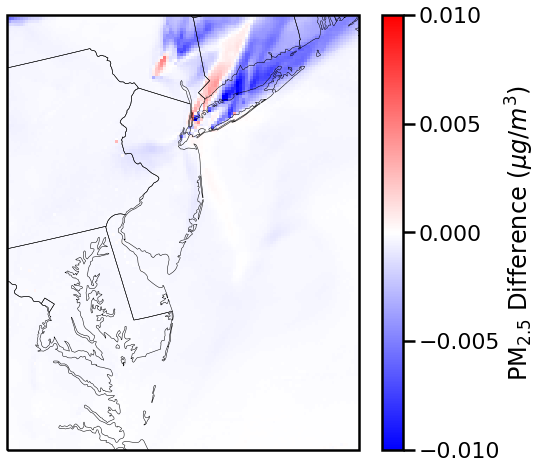

In [61]:
conc_map(pm25_mean_diff, cmap=cm.get_cmap('bwr'), ax=None, cartopy_crs=cartopy_crs, proj_bounds=proj_bounds, 
    vmin=-0.01, vmax=0.01, cbar_ticks=[-0.01, -0.005, 0, 0.005, 0.01], cbar_label='PM$_{2.5}$ Difference ($\mu g/m^{3}$)')

<GeoAxesSubplot:title={'center':'time = 2016-08-07T23:00:00'}, xlabel='longitude', ylabel='latitude'>

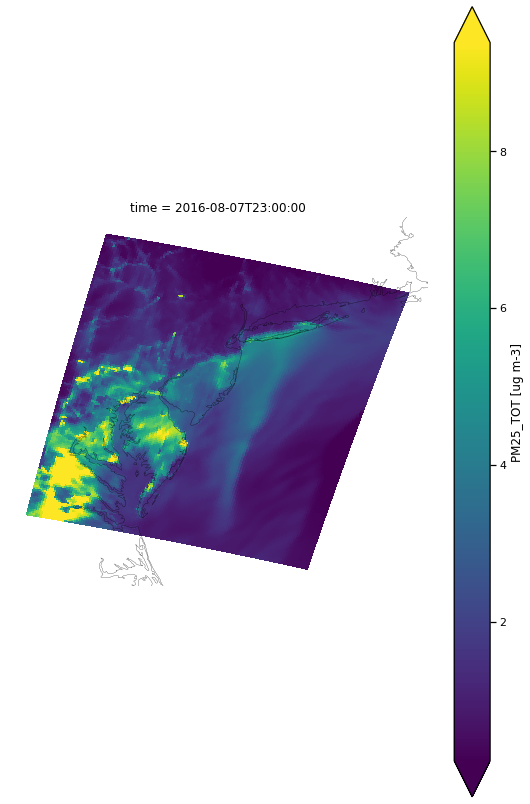

In [13]:
# If you just want to do a quick map visualization
c_base.PM25_TOT.sel(time='2016-08-07 23').monet.quick_map(robust=True)

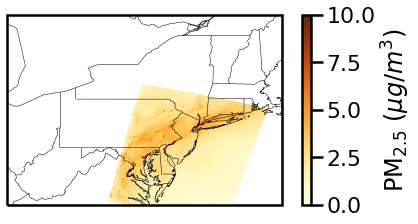

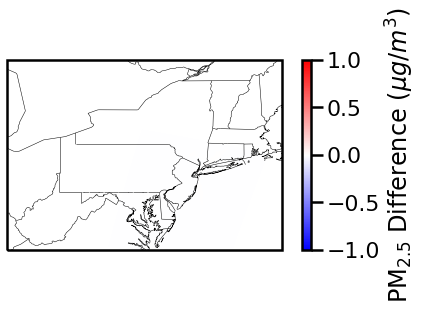

In [62]:
pm25_mean = c_ren.PM25_TOT.mean(dim='time')
pm25_mean_diff = (c_ren.PM25_TOT - c_base.PM25_TOT).mean(dim='time')
# pm25_pct_diff = (c1.PM25_TOT - c.PM25_TOT) / c.PM25_TOT
# pm25_mean_pct_diff = pm25_pct_diff.mean(dim='time')

plots.conc_compare(pm25_mean, pm25_mean_diff, extent = [-83, -70, 37, 46],
             vmin1=0, vmax1=10, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('YlOrBr'), cmap2=cm.get_cmap('bwr'),
             cbar_label1='PM$_{2.5}$ ($\mu g/m^{3}$)', cbar_label2='PM$_{2.5}$ Difference ($\mu g/m^{3}$)',
             figsize=(7,3.5), savefig=True, figpath1='../cmaqpy/data/plots/PM2.5.png', 
             figpath2='../cmaqpy/data/plots/PM2.5_diff.png')

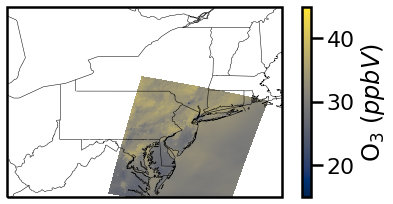

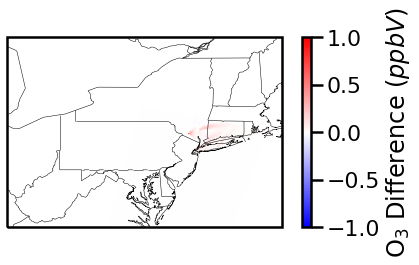

In [63]:
o3_mean = c_ren.O3.mean(dim='time')
o3_mean_diff = (c_ren.O3 - c_base.O3).mean(dim='time')
# o3_pct_diff = (c1.O3 - c.O3) / c.O3
# o3_mean_pct_diff = o3_pct_diff.mean(dim='time')

plots.conc_compare(o3_mean, o3_mean_diff, extent = [-83, -70, 37, 46],
             vmin1=15, vmax1=45, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('cividis'), cmap2=cm.get_cmap('bwr'),
             cbar_label1='O$_{3}$ ($ppbV$)', cbar_label2='O$_{3}$ Difference ($ppbV$)',
             figsize=(7,3.5), savefig=True, figpath1='../cmaqpy/data/plots/O3.png', 
             figpath2='../cmaqpy/data/plots/O3_diff.png')